In [1]:
from ARGUS_taskid_train import ARGUS_taskid_train

In [2]:
nnet = ARGUS_taskid_train("../ARGUS/ARGUS_taskid.cfg", "vfold", 0)
nnet.setup_vfold_files()

PTX : num images = 62
PNB : num images = 31
ONS : num images = 25
ETT : num images = 46
Total num images = 164
Num images / labels = 164 164
**** VFold = 0 : 132 16 16
**** VFold = 1 : 131 16 17
**** VFold = 2 : 130 17 17
**** VFold = 3 : 130 17 17
**** VFold = 4 : 130 17 17
**** VFold = 5 : 131 17 16
**** VFold = 6 : 132 16 16
**** VFold = 7 : 132 16 16
**** VFold = 8 : 132 16 16
**** VFold = 9 : 132 16 16


In [3]:
nnet.setup_training_vfold(0)

In [4]:
nnet.verify_vfold()

<class 'monai.data.meta_tensor.MetaTensor'> (12, 1, 256, 256) tensor([1, 1, 0, 0, 0, 3, 1, 1, 2, 0, 2, 2]) torch.Size([12])


Data_TaskId/PTXNS_Image_262499828648_clean.mha


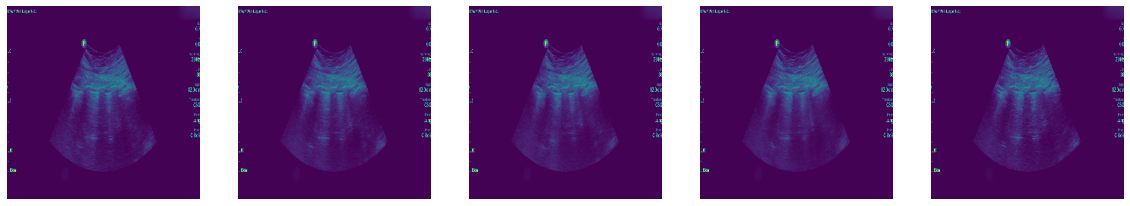

Label = 0
Data_TaskId/PTXNS_image_573611404207_CLEAN.mha


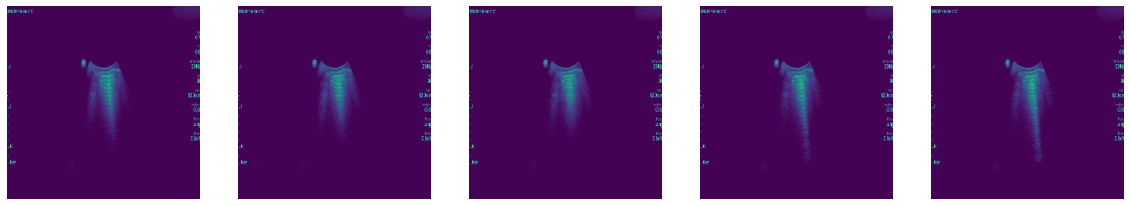

Label = 0
Data_TaskId/PTXS_image_128688523296793_CLEAN.mha


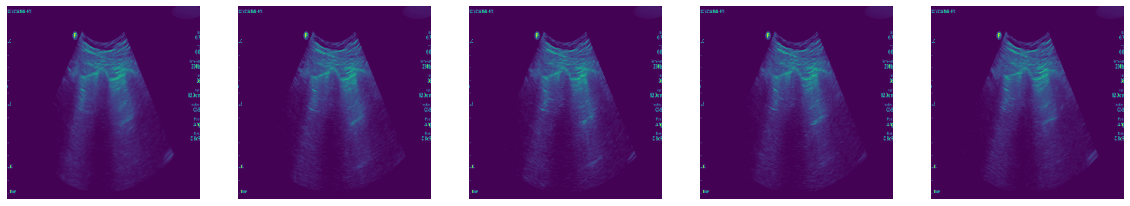

Label = 0
Data_TaskId/PTXS_image_73815992352100_clean.mha


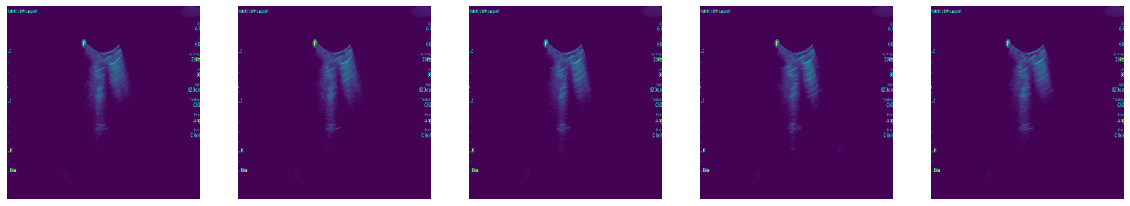

Label = 0
Data_TaskId/PNBP_3. 205 AC_Video 2.mha


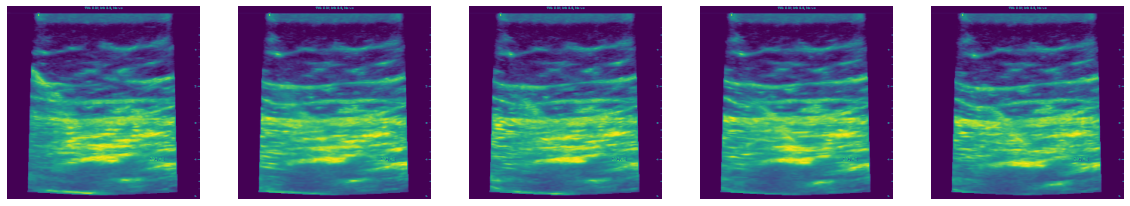

Label = 1
Data_TaskId/ONSDN_4. 191.1 Right Long_Video 1.mha


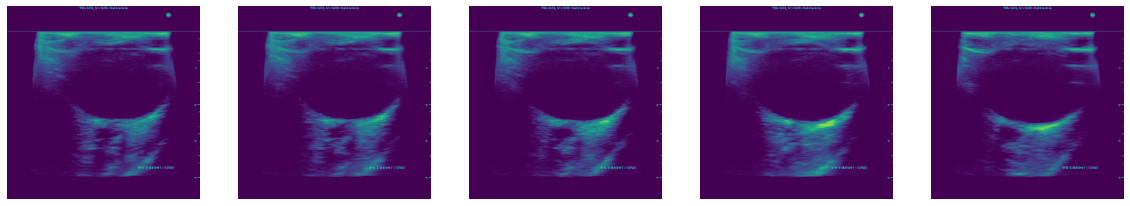

Label = 2
Data_TaskId/ETTN_10. 99C_Video.mha


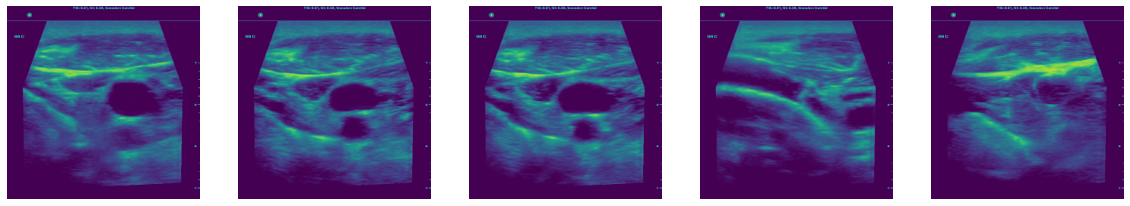

Label = 3


In [5]:
for i in range(0,len(nnet.train_files[0]),20):
    nnet.view_training_image(i)

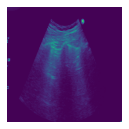

Label = 0


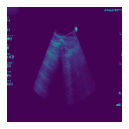

Label = 0


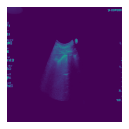

Label = 0


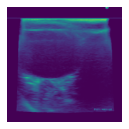

Label = 2


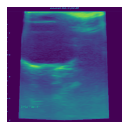

Label = 2


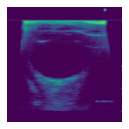

Label = 2


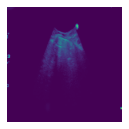

Label = 0


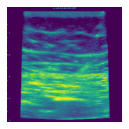

Label = 1


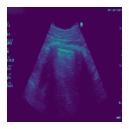

Label = 0


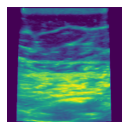

Label = 1


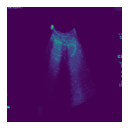

Label = 0


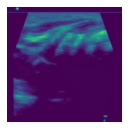

Label = 3


In [6]:
nnet.view_training_vfold_batch(0)

In [7]:
run_num = 0
nnet.train_vfold(run_num)

----------
0: epoch 1/50
0 / 11, train_loss: 1.5434
1 / 11, train_loss: 1.2845
2 / 11, train_loss: 1.0849
3 / 11, train_loss: 1.2446
4 / 11, train_loss: 0.8154
5 / 11, train_loss: 0.9814
6 / 11, train_loss: 1.1122
7 / 11, train_loss: 0.6563
8 / 11, train_loss: 0.8959
9 / 11, train_loss: 0.6362
10 / 11, train_loss: 0.6500
0 epoch 1 average loss: 1.0905
----------
0: epoch 2/50
0 / 11, train_loss: 0.6190
1 / 11, train_loss: 0.6458
2 / 11, train_loss: 0.5718
3 / 11, train_loss: 0.3770
4 / 11, train_loss: 0.6002
5 / 11, train_loss: 0.3750
6 / 11, train_loss: 0.3103
7 / 11, train_loss: 0.3818
8 / 11, train_loss: 0.4283
9 / 11, train_loss: 0.7574
10 / 11, train_loss: 0.4524
0 epoch 2 average loss: 0.5519
Current epoch: 2
   Current portion correct: 0.2500
   Current accuracy value: 1.0962
   Current mean accuracy value: 0.0000
Best mean accuracy value: -1.0000
    at epoch: -1
----------
0: epoch 3/50
0 / 11, train_loss: 0.3748
1 / 11, train_loss: 0.4101
2 / 11, train_loss: 0.8916
3 / 11, tr